### Imports

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K

from IPython.display import display as display_fn
from IPython.display import Image, clear_output

### Utilities

As before, we've provided some utility functions below to help in loading, visualizing, and preprocessing the images.

In [2]:
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor) 


def load_img(path_to_img):
  '''loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image


def load_images(content_path, style_path):
  '''loads the content and path images as tensors'''
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image


def imshow(image, title=None):
  '''displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)
    
    
def show_images_with_objects(images, titles=[]):
  '''displays a row of images with corresponding titles'''
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)


def clip_image_values(image, min_value=0.0, max_value=255.0):
  '''clips the image pixel values by the given min and max'''
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)


def preprocess_image(image):
  '''preprocesses a given image to use with Inception model'''
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 127.5) - 1.0

  return image

### Load the Images

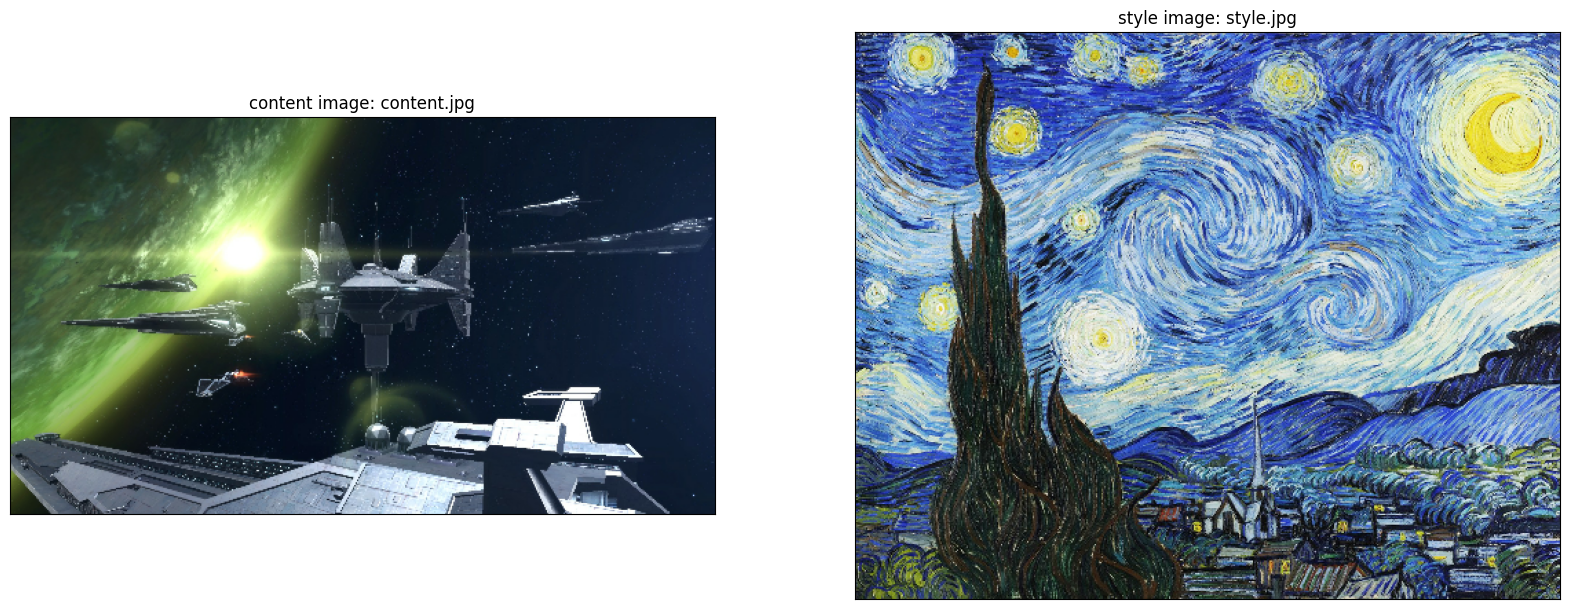

In [3]:
content_image_path = "content.jpg"
style_image_path = "style.jpg"

content_image, style_image = load_images(content_image_path, style_image_path)
show_images_with_objects([content_image, style_image], 
                         titles=[f'content image: {content_image_path}',
                                 f'style image: {style_image_path}'])

## Build the feature extractor

Next, you will inspect the layers of the Inception model.

In [4]:
# choose the content layer and put in a list
content_layers = ["conv2d_88"]

# combine the content and style layers into one list
style_layers = ["conv2d", 
                "conv2d_1",
                "conv2d_2",
                "conv2d_3",
                "conv2d_4"]
    
# combine the content and style layers into one list
content_and_style_layers = style_layers + content_layers

# count the number of content layers and style layers.
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

In [5]:
def inception_model(layer_names):
    # Load InceptionV3 with the imagenet weights and **without** the fully-connected layer at the top of the network
    inception = tf.keras.applications.inception_v3.InceptionV3(include_top= False)

    # Freeze the weights of the model's layers
    inception.trainable = False

    # Create a list of layer objects that are specified by layer_names
    output_layers = [inception.get_layer(name).output for name in layer_names]

    # Create the model that outputs the content and style layers
    model = tf.keras.models.Model(inputs = inception.input, outputs = output_layers)

    return model

inception = inception_model(content_and_style_layers)


### Calculate style loss

The style loss is the average of the squared differences between the features and targets.

In [6]:
def get_style_loss(features, targets):
    style_loss = tf.reduce_mean(tf.square(targets - features))
    return style_loss

### Calculate content loss

Calculate the sum of the squared error between the features and targets, then multiply by a scaling factor (0.5).

In [7]:
def get_content_loss(features, targets):
    content_loss = 0.5 * tf.reduce_sum(tf.square(features - targets))
    return content_loss

### Calculate the gram matrix

In [8]:
def gram_matrix(input_tensor):
    # calculate the gram matrix of the input tensor
    gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 

    # get the height and width of the input tensor
    input_shape = tf.shape(input_tensor) 
    height = input_shape[1] 
    width = input_shape[2] 

    # get the number of locations (height times width), and cast it as a tf.float32
    num_locations = tf.cast(height * width, tf.float32)

    # scale the gram matrix by dividing by the number of locations
    scaled_gram = gram / num_locations
    
    return scaled_gram

### Get the style image features

In [9]:
def get_style_image_features(image):
    # preprocess the image using the given preprocessing function
    preprocessed_style_image = preprocess_image(image)

    # get the outputs from the inception model that you created using inception_model()
    outputs = inception(preprocessed_style_image)

    # Get just the style feature layers (exclude the content layer)
    style_outputs = outputs[:NUM_STYLE_LAYERS]

    # for each style layer, calculate the gram matrix for that layer and store these results in a list
    gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs]

    return gram_style_features

### Get content image features

In [10]:
def get_content_image_features(image):
    # preprocess the image using the given preprocessing function
    preprocessed_content_image = preprocess_image(image)

    # get the outputs from the inception model that you created using inception_model()
    outputs = inception(preprocessed_content_image)

    # Get just the content feature layer
    content_outputs = outputs[NUM_STYLE_LAYERS:]

    return content_outputs

### Calculate the total loss

In [11]:
def get_style_content_loss(style_targets, style_outputs, content_targets, 
                           content_outputs, style_weight, content_weight):
    # sum of the style losses
    style_loss = tf.add_n([get_style_loss(style_output, style_target)
                            for style_output, style_target in zip(style_outputs, style_targets)])
    
    # sum of the content losses
    content_loss = tf.add_n([get_content_loss(content_output, content_target)
                            for content_output, content_target in zip(content_outputs, content_targets)])
    
    # scale the style loss by multiplying by the style weight and dividing by the number of style layers
    style_loss = style_loss * style_weight / NUM_STYLE_LAYERS

    # scale the content loss by multiplying by the content weight and dividing by the number of content layers
    content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS
    
    # sum up the style and content losses
    total_loss = style_loss + content_loss

    return total_loss

### Calculate gradients

In [12]:
def calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight):
    with tf.GradientTape() as tape: 
        # get style outputs
        style_outputs = get_style_image_features(image)

        # get content outputs
        content_outputs = get_content_image_features(image)

        # get the style/content losses
        loss = get_style_content_loss(style_targets, style_outputs, content_targets, 
                                      content_outputs, style_weight, content_weight)
    
    # calculate gradients using the tape.gradient method
    gradients = tape.gradient(loss, image)

    return gradients

### Update the image with the style

In [13]:
def update_image_with_style(image, style_targets, content_targets, style_weight, 
                            content_weight, optimizer):
    # calculate gradients using the function that you just defined.
    gradients = calculate_gradients(image, style_targets, content_targets,
                                    style_weight, content_weight)
    
    # apply the gradients to the given image
    optimizer.apply_gradients([(gradients, image)])

    # Clip the image using the given clip_image_values() function
    image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

### Generate the stylized image

In [14]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, 
                       optimizer='adam', epochs=1, steps_per_epoch=1):
    images = []
    step = 0

    # get the style image features 
    style_targets = get_style_image_features(style_image)
    
    # get the content image features
    content_targets = get_content_image_features(content_image)

    # initialize the generated image for updates
    generated_image = tf.cast(content_image, dtype=tf.float32)
    generated_image = tf.Variable(generated_image) 
  
    # collect the image updates starting from the content image
    images.append(content_image)
  
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
    
        # Update the image with the style using the function that you defined
        update_image_with_style(generated_image, style_targets, content_targets, 
                              style_weight, content_weight, optimizer)
    

        print(".", end='')
        if (m + 1) % 10 == 0:
            images.append(generated_image)
    
        # display the current stylized image
        clear_output(wait=True)
        display_image = tensor_to_image(generated_image)
        display_fn(display_image)

        # append to the image collection for visualization later
        images.append(generated_image)
        print("Train step: {}".format(step))
  
    # convert to uint8 (expected dtype for images with pixels in the range [0,255])
    generated_image = tf.cast(generated_image, dtype=tf.uint8)
  
    return generated_image, images

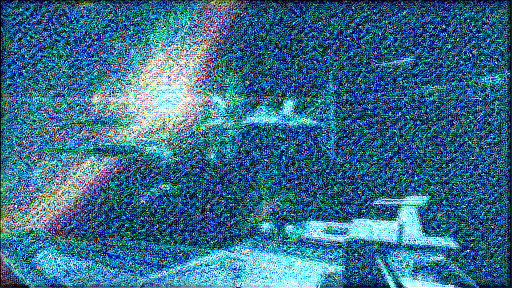

Train step: 1000


In [15]:
# define style and content weight
style_weight =  1
content_weight = 1e-32 

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=80.0, decay_steps=100, decay_rate=0.80
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=10, steps_per_epoch=100)